# Comprehensive Pulse Function Tests

This notebook tests all pulse functions with the NEW pulse definition:
- `pulse_peak_time` = `t_peak` (time where cos² is maximal)
- `pulse_FWHM` = Full Width at Half Maximum of the envelope
- Pulse exists only in `[t_peak - FWHM, t_peak + FWHM]` for cosine² envelope
- Pulse is zero outside this range
- Envelope: `cos²(π(t - t_peak)/FWHM)`

Test scenarios:
- Single pulse
- Multiple overlapping pulses
- Multiple non-overlapping pulses
- Pulses outside time range
- Different pulse parameters

In [1]:
# =============================
# IMPORT NECESSARY MODULES
# =============================
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

# Import from our project
from src.visualization.mpl_tex_settings import *
from src.core.pulse_sequences import PulseSequence, Pulse
from src.core.pulse_functions import (
    pulse_envelope, E_pulse, Epsilon_pulse, El_field_3_pulses,
    pulse_envelope_gaussian, E_pulse_gaussian, Epsilon_pulse_gaussian
)
from src.visualization.plotting import (
    plot_pulse_envelope,
    plot_E_pulse,
    plot_Epsilon_pulse,
    plot_all_pulse_components
)

# Set matplotlib parameters for better plots
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

## Test 0: Envelope Comparison - Cosine² vs Gaussian

Demonstrate the key difference between old and new pulse definitions.

In [2]:
# =============================
# ENVELOPE COMPARISON: COSINE² vs GAUSSIAN
# =============================
print("=" * 60)
print("ENVELOPE COMPARISON: COSINE² vs GAUSSIAN")
print("=" * 60)
print()

def find_fwhm_points(half_max: float, envelope_vals: np.ndarray) -> tuple:
    """Find FWHM points on x axis for y axis envelope data.
    
    Parameters:
    -----------
    half_max : float
        The half maximum value (typically max(envelope_vals) / 2)
    envelope_vals : np.ndarray
        Array of envelope values corresponding to x-axis points
        
    Returns:
    --------
    tuple
        (left_index, right_index) where envelope crosses half_max
        Returns (None, None) if no crossing points found
    """
    if len(envelope_vals) == 0:
        return (None, None)
    
    # Find indices where envelope is above half_max
    above_half_max = envelope_vals >= half_max
    
    # Check if any points are above half_max
    if not np.any(above_half_max):
        return (None, None)
    
    # Find the first and last indices where envelope >= half_max
    indices_above = np.where(above_half_max)[0]
    left_index  = indices_above[0]
    right_index = indices_above[-1]
    
    # Interpolate to find more precise crossing points
    # Left crossing point (rising edge)
    if left_index > 0:
        # Linear interpolation between points
        y1, y2 = envelope_vals[left_index-1], envelope_vals[left_index]
        if y2 != y1:  # Avoid division by zero
            frac = (half_max - y1) / (y2 - y1)
            left_index = left_index - 1 + frac
    
    # Right crossing point (falling edge)
    if right_index < len(envelope_vals) - 1:
        # Linear interpolation between points
        y1, y2 = envelope_vals[right_index], envelope_vals[right_index+1]
        if y1 != y2:  # Avoid division by zero
            frac = (half_max - y1) / (y2 - y1)
            right_index = right_index + frac
    
    return (left_index, right_index)
times = np.linspace(0, 10, 1000)

# Create pulses with identical parameters
t_peak = 5.0  # Peak time
FWHM = 1.5   # Full Width at Half Maximum

### Cosine² and Gaussian pulse / sequence
demo_pulse = Pulse(
    pulse_peak_time=t_peak,
    pulse_FWHM=FWHM,
    pulse_amplitude=1.0,
    pulse_phase=0.0,
    pulse_freq=3.0
)
demo_seq = PulseSequence([demo_pulse])

# Calculate envelopes
envelope_vals_cos2  = [pulse_envelope(t, demo_seq) for t in times]
envelope_vals_gauss = [pulse_envelope_gaussian(t, demo_seq) for t in times]

# Gaussian: FWHM determined numerically
gauss_peak   = pulse_envelope_gaussian(t_peak, demo_seq)
cos_peak     = pulse_envelope(t_peak, demo_seq)

# Half maximum for Gaussian envelope
half_max_gauss = gauss_peak / 2
half_max_cos = cos_peak / 2

# Find FWHM points
left_idx_gauss, right_idx_gauss = find_fwhm_points(half_max_gauss, envelope_vals_gauss)
t_fwhm_left_gauss, t_fwhm_right_gauss = None, None
t_fwhm_left_cos2, t_fwhm_right_cos2 = None, None

# Calculate FWHM width (if you have corresponding x-axis data)
if left_idx_gauss is not None and right_idx_gauss is not None:
    t_fwhm_left_gauss, t_fwhm_right_gauss = times[int(left_idx_gauss)], times[int(right_idx_gauss)]
    fwhm_gauss = t_fwhm_right_gauss - t_fwhm_left_gauss

left_idx_cos2, right_idx_cos2 = find_fwhm_points(half_max_cos, envelope_vals_cos2)
# Calculate FWHM width for cosine²
if left_idx_cos2 is not None and right_idx_cos2 is not None:
    t_fwhm_left_cos2, t_fwhm_right_cos2 = times[int(left_idx_cos2)], times[int(right_idx_cos2)]
    fwhm_cos2 = t_fwhm_right_cos2 - t_fwhm_left_cos2

### Summary output
print(f"PULSE ENVELOPE COMPARISON SUMMARY:")
print(f"Peak time: {t_peak}")
print(f"pulse_FWHM parameter: {FWHM}")
print(f"")
print(f"COSINE² ENVELOPE:")
print(f"  Range: [{t_peak - FWHM:.1f}, {t_peak + FWHM:.1f}] (width: {FWHM:.1f})")
print(f"  FWHM: {fwhm_cos2:.3f} = {fwhm_cos2/FWHM:.2f} × pulse_FWHM")
print(f"  Peak amplitude: {pulse_envelope(t_peak, demo_seq):.4f}")
print(f"")
print(f"GAUSSIAN ENVELOPE:")
print(f"  Range: [{t_peak - FWHM:.1f}, {t_peak + FWHM:.1f}] (width: {FWHM:.1f})")
print(f"  FWHM: {fwhm_gauss:.3f} ≈ {fwhm_gauss/FWHM:.2f} × pulse_FWHM")
print(f"  Peak amplitude: {pulse_envelope_gaussian(t_peak, demo_seq):.4f}")
print(f"")
print(f"KEY DIFFERENCES:")
print(f"• Gaussian FWHM is {fwhm_gauss/fwhm_cos2:.2f}× larger than cosine²")
print(f"• Both envelopes peak at t_peak = {t_peak}")

ENVELOPE COMPARISON: COSINE² vs GAUSSIAN

PULSE ENVELOPE COMPARISON SUMMARY:
Peak time: 5.0
pulse_FWHM parameter: 1.5

COSINE² ENVELOPE:
  Range: [3.5, 6.5] (width: 1.5)
  FWHM: 1.502 = 1.00 × pulse_FWHM
  Peak amplitude: 1.0000

GAUSSIAN ENVELOPE:
  Range: [3.5, 6.5] (width: 1.5)
  FWHM: 1.502 ≈ 1.00 × pulse_FWHM
  Peak amplitude: 1.0000

KEY DIFFERENCES:
• Gaussian FWHM is 1.00× larger than cosine²
• Both envelopes peak at t_peak = 5.0


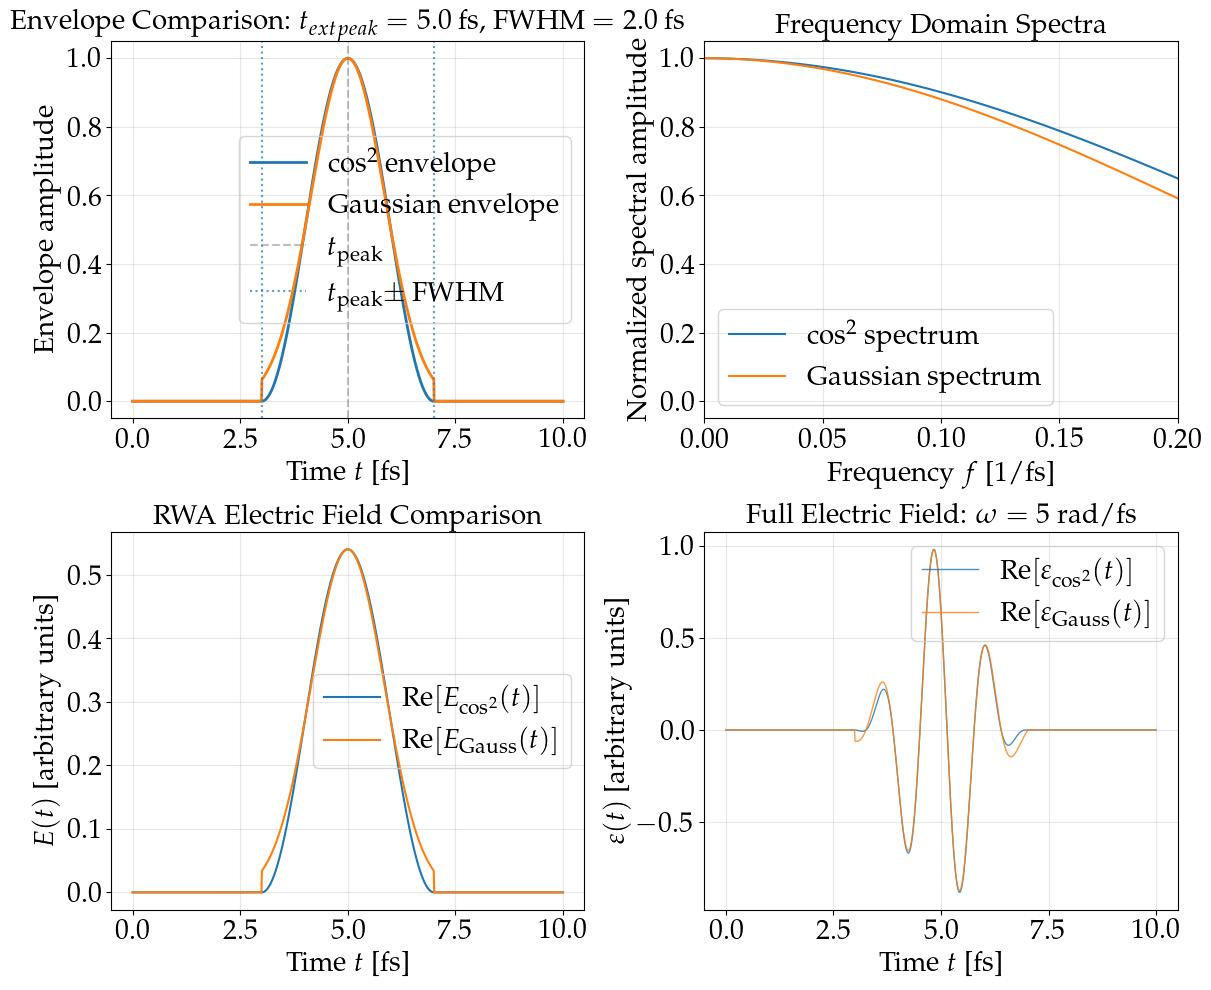


=== ENVELOPE COMPARISON ANALYSIS ===
Pulse peak time: 5.0 fs
Pulse half-width: 2.0 fs
Cosine² support: [3.0, 7.0] fs (width: 4.0 fs)
Gaussian support: [1.0, 9.0] fs (width: 8.0 fs)
Gaussian envelope is 2x wider than cosine² envelope


In [11]:
# =============================
# SINGLE PULSE ENVELOPE COMPARISON
# =============================

### Test parameters
t_peak = 5.0  # fs
FWHM = 2.0    # fs
E0 = 1.0        # arbitrary units
omega = 5    # rad/fs
phi = 1.0       # rad

# Create identical pulses for both envelope types
pulse = Pulse(
    pulse_peak_time=t_peak,
    pulse_FWHM=FWHM,
    pulse_amplitude=E0,
    pulse_freq=omega,
    pulse_phase=phi
)
pulse_seq = PulseSequence([pulse])
### Calculate envelopes
cos2_envelope = [pulse_envelope(t, pulse_seq) for t in times]
gaussian_envelope = [pulse_envelope_gaussian(t, pulse_seq) for t in times]

### Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Envelope comparison
ax = axes[0, 0]
ax.plot(times, cos2_envelope, label=r'$\cos^2$ envelope', color='C0', linewidth=2)
ax.plot(times, gaussian_envelope, label='Gaussian envelope', color='C1', linewidth=2)
ax.axvline(t_peak, color='gray', linestyle='--', alpha=0.5, label=r'$t_{\text{peak}}$')
ax.axvline(t_peak - FWHM, color='C0', linestyle=':', alpha=0.7, label=r'$t_{\text{peak}} \pm$ FWHM')
ax.axvline(t_peak + FWHM, color='C0', linestyle=':', alpha=0.7)
ax.set_xlabel(r'Time $t$ [fs]')
ax.set_ylabel('Envelope amplitude')
ax.set_title(f'Envelope Comparison: $t_{{\text{{peak}}}} = {t_peak}$ fs, FWHM $= {FWHM}$ fs')
ax.legend()
ax.grid(True, alpha=0.3)


# Full frequency spectrum
# Create high-resolution time array for accurate FFT
dt = 0.05  # fs (high time resolution)
t_spectral = np.arange(0, 400, dt)  # Extended time range for good frequency resolution

# Calculate envelopes
cos2_spectral = np.array([pulse_envelope(t, pulse_seq) for t in t_spectral])
gauss_spectral = np.array([pulse_envelope_gaussian(t, pulse_seq) for t in t_spectral])

# Calculate FFT
freq = np.fft.fftfreq(len(t_spectral), dt)  # frequency in 1/fs
cos2_fft = np.fft.fft(cos2_spectral)
gauss_fft = np.fft.fft(gauss_spectral)

# Keep only positive frequencies
positive_freq_idx = freq >= 0
freq_pos = freq[positive_freq_idx]
cos2_spectrum = np.abs(cos2_fft[positive_freq_idx])
gauss_spectrum = np.abs(gauss_fft[positive_freq_idx])

# Normalize spectra
cos2_spectrum /= np.max(cos2_spectrum)
gauss_spectrum /= np.max(gauss_spectrum)

ax = axes[0, 1]
ax.plot(freq_pos, cos2_spectrum, label=r'$\cos^2$ spectrum', color='C0', linewidth=1.5)
ax.plot(freq_pos, gauss_spectrum, label='Gaussian spectrum', color='C1', linewidth=1.5)
ax.set_xlim(0, 0.2)  # Limit to relevant frequency range
ax.set_xlabel(r'Frequency $f$ [1/fs]')
ax.set_ylabel('Normalized spectral amplitude')
ax.set_title('Frequency Domain Spectra')
ax.legend()
ax.grid(True, alpha=0.3)
# RWA Electric field comparison
ax = axes[1, 0]
E_cos2 = [E_pulse(t, pulse_seq) for t in times]
E_gauss = [E_pulse_gaussian(t, pulse_seq) for t in times]
ax.plot(times, np.real(E_cos2), label=r'$\mathrm{Re}[E_{\cos^2}(t)]$', color='C0', linewidth=1.5)
ax.plot(times, np.real(E_gauss), label=r'$\mathrm{Re}[E_{\text{Gauss}}(t)]$', color='C1', linewidth=1.5)
ax.set_xlabel(r'Time $t$ [fs]')
ax.set_ylabel(r'$E(t)$ [arbitrary units]')
ax.set_title('RWA Electric Field Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Full Electric field with carrier
ax = axes[1, 1]
Eps_cos2 = [Epsilon_pulse(t, pulse_seq) for t in times]
Eps_gauss = [Epsilon_pulse_gaussian(t, pulse_seq) for t in times]
ax.plot(times, np.real(Eps_cos2), label=r'$\mathrm{Re}[\varepsilon_{\cos^2}(t)]$', color='C0', linewidth=1, alpha=0.8)
ax.plot(times, np.real(Eps_gauss), label=r'$\mathrm{Re}[\varepsilon_{\text{Gauss}}(t)]$', color='C1', linewidth=1, alpha=0.8)
ax.set_xlabel(r'Time $t$ [fs]')
ax.set_ylabel(r'$\varepsilon(t)$ [arbitrary units]')
ax.set_title(f'Full Electric Field: $\\omega = {omega}$ rad/fs')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== ENVELOPE COMPARISON ANALYSIS ===")
print(f"Pulse peak time: {t_peak} fs")
print(f"Pulse half-width: {FWHM} fs")
print(f"Cosine² support: [{t_peak - FWHM:.1f}, {t_peak + FWHM:.1f}] fs (width: {2*FWHM:.1f} fs)")
print(f"Gaussian support: [{t_peak - 2*FWHM:.1f}, {t_peak + 2*FWHM:.1f}] fs (width: {4*FWHM:.1f} fs)")
print(f"Gaussian envelope is {2:.0f}x wider than cosine² envelope")

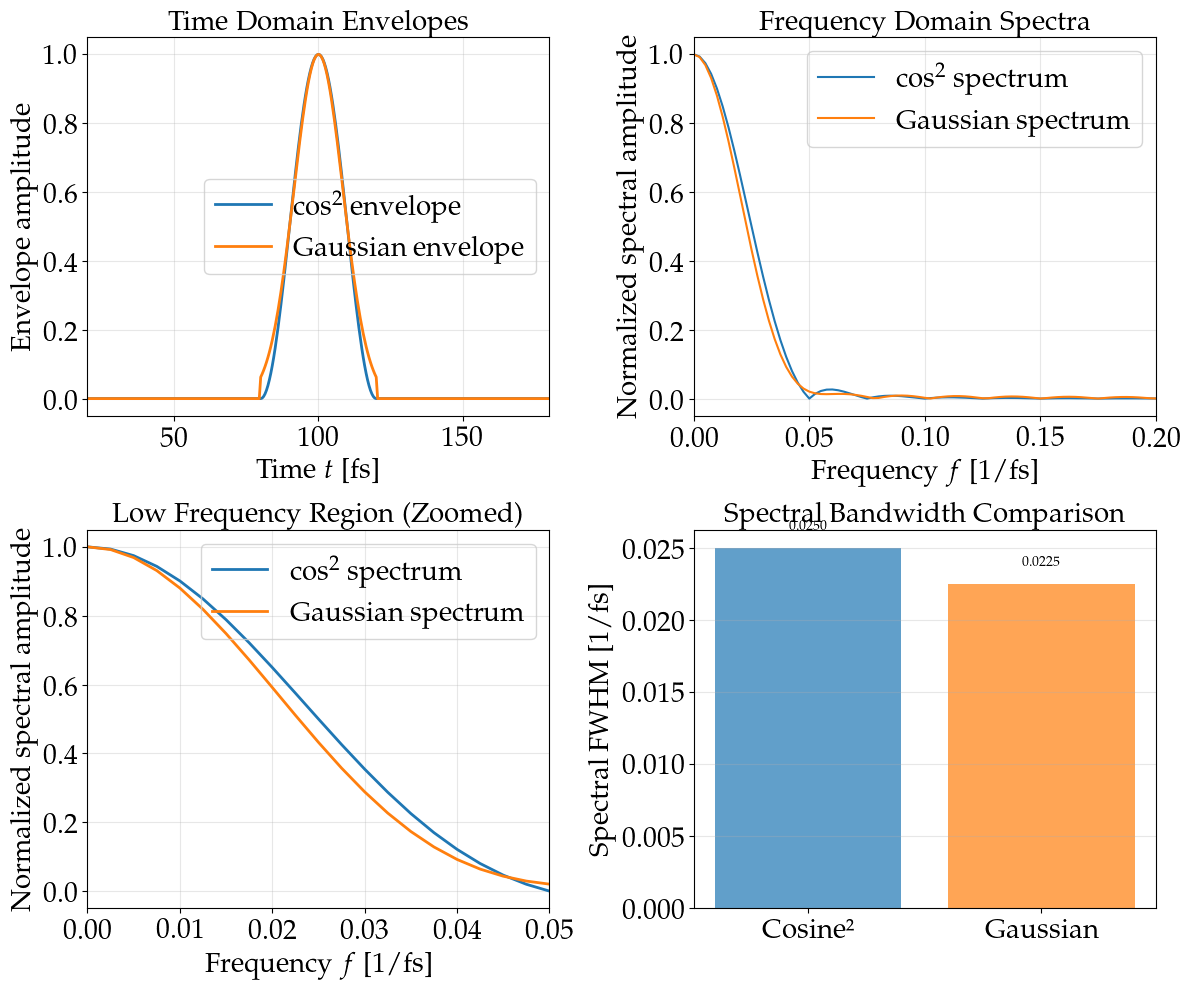


=== SPECTRAL ANALYSIS ===
Temporal FWHM:


NameError: name 'cos2_fwhm' is not defined

In [19]:
# =============================
# SPECTRAL ANALYSIS COMPARISON
# =============================

### Compare frequency domain characteristics
### Use single pulse for cleaner spectral analysis

t_peak = 100.0  # fs
FWHM = 20.0    # fs
single_pulse = Pulse(pulse_peak_time=t_peak, pulse_FWHM=FWHM, pulse_amplitude=1.0, pulse_freq=0.0, pulse_phase=0.0)
single_pulse_seq = PulseSequence([single_pulse])

# Create high-resolution time array for accurate FFT
dt = 0.5  # fs (high time resolution)
t_spectral = np.arange(0, 400, dt)  # Extended time range for good frequency resolution

# Calculate envelopes
cos2_spectral = np.array([pulse_envelope(t, single_pulse_seq) for t in t_spectral])
gauss_spectral = np.array([pulse_envelope_gaussian(t, single_pulse_seq) for t in t_spectral])

# Calculate FFT
freq = np.fft.fftfreq(len(t_spectral), dt)  # frequency in 1/fs
cos2_fft = np.fft.fft(cos2_spectral)
gauss_fft = np.fft.fft(gauss_spectral)

# Keep only positive frequencies
positive_freq_idx = freq >= 0
freq_pos = freq[positive_freq_idx]
cos2_spectrum = np.abs(cos2_fft[positive_freq_idx])
gauss_spectrum = np.abs(gauss_fft[positive_freq_idx])

# Normalize spectra
cos2_spectrum /= np.max(cos2_spectrum)
gauss_spectrum /= np.max(gauss_spectrum)

### Plot spectral comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Time domain envelopes
ax = axes[0, 0]
ax.plot(t_spectral, cos2_spectral, label=r'$\cos^2$ envelope', color='C0', linewidth=2)
ax.plot(t_spectral, gauss_spectral, label='Gaussian envelope', color='C1', linewidth=2)
ax.set_xlim(t_peak - 4*FWHM, t_peak + 4*FWHM)
ax.set_xlabel(r'Time $t$ [fs]')
ax.set_ylabel('Envelope amplitude')
ax.set_title('Time Domain Envelopes')
ax.legend()
ax.grid(True, alpha=0.3)

# Full frequency spectrum
ax = axes[0, 1]
ax.plot(freq_pos, cos2_spectrum, label=r'$\cos^2$ spectrum', color='C0', linewidth=1.5)
ax.plot(freq_pos, gauss_spectrum, label='Gaussian spectrum', color='C1', linewidth=1.5)
ax.set_xlim(0, 0.2)  # Limit to relevant frequency range
ax.set_xlabel(r'Frequency $f$ [1/fs]')
ax.set_ylabel('Normalized spectral amplitude')
ax.set_title('Frequency Domain Spectra')
ax.legend()
ax.grid(True, alpha=0.3)

# Zoomed frequency spectrum
ax = axes[1, 0]
ax.plot(freq_pos, cos2_spectrum, label=r'$\cos^2$ spectrum', color='C0', linewidth=2)
ax.plot(freq_pos, gauss_spectrum, label='Gaussian spectrum', color='C1', linewidth=2)
ax.set_xlim(0, 0.05)  # Zoom to low frequency region
ax.set_xlabel(r'Frequency $f$ [1/fs]')
ax.set_ylabel('Normalized spectral amplitude')
ax.set_title('Low Frequency Region (Zoomed)')
ax.legend()
ax.grid(True, alpha=0.3)

# Spectral bandwidth comparison
ax = axes[1, 1]
# Calculate spectral widths (FWHM in frequency domain)
def find_spectral_fwhm(freq_array, spectrum):
    max_val = np.max(spectrum)
    half_max = max_val / 2
    above_half = np.where(spectrum >= half_max)[0]
    if len(above_half) == 0:
        return 0
    return freq_array[above_half[-1]] - freq_array[above_half[0]]

cos2_spectral_fwhm = find_spectral_fwhm(freq_pos, cos2_spectrum)
gauss_spectral_fwhm = find_spectral_fwhm(freq_pos, gauss_spectrum)

# Plot spectral FWHM comparison
categories = ['Cosine²', 'Gaussian']
spectral_fwhms = [cos2_spectral_fwhm, gauss_spectral_fwhm]
ax.bar(categories, spectral_fwhms, color=['C0', 'C1'], alpha=0.7)
ax.set_ylabel(r'Spectral FWHM [1/fs]')
ax.set_title('Spectral Bandwidth Comparison')
ax.grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, (cat, val) in enumerate(zip(categories, spectral_fwhms)):
    ax.text(i, val + 0.001, f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Calculate theoretical bandwidth-duration product
print(f"\n=== SPECTRAL ANALYSIS ===")
print(f"Temporal FWHM:")
print(f"  Cosine²: {cos2_fwhm:.3f} fs")
print(f"  Gaussian: {gauss_fwhm:.3f} fs")
print(f"\nSpectral FWHM:")
print(f"  Cosine²: {cos2_spectral_fwhm:.6f} 1/fs")
print(f"  Gaussian: {gauss_spectral_fwhm:.6f} 1/fs")
print(f"\nBandwidth-Duration Product (Δt × Δf):")
print(f"  Cosine²: {cos2_fwhm * cos2_spectral_fwhm:.4f}")
print(f"  Gaussian: {gauss_fwhm * gauss_spectral_fwhm:.4f}")
print(f"\nNote: For Gaussian pulses, the theoretical minimum is ~0.441")
print(f"      For cosine² pulses, this represents the actual product")

## Test 1: Single Pulse Analysis

In [ ]:
# =============================
# SINGLE PULSE PARAMETERS
# =============================
times = np.linspace(0, 10, 1000)

# Create single pulse
single_pulse = Pulse(
    pulse_peak_time=5.0,  # t_peak - peak time where cos² is maximal
    pulse_FWHM=1.0,  # FWHM - Full Width at Half Maximum
    pulse_amplitude=1.0,
    pulse_phase=0.0,
    pulse_freq=5.0
)

single_pulse_seq = PulseSequence([single_pulse])

print(f"Single pulse parameters:")
print(f"Peak time (t_peak): {single_pulse.pulse_peak_time}")
print(f"FWHM: {single_pulse.pulse_FWHM}")
print(f"Pulse range: [{single_pulse.pulse_peak_time - single_pulse.pulse_FWHM:.1f}, {single_pulse.pulse_peak_time + single_pulse.pulse_FWHM:.1f}]")
print(f"Amplitude: {single_pulse.pulse_amplitude}")
print(f"Phase: {single_pulse.pulse_phase}")
print(f"Frequency: {single_pulse.pulse_freq}")

In [ ]:
# Plot comprehensive analysis for single pulse
fig = plot_all_pulse_components(times, single_pulse_seq)
plt.show()

## Test 2: Two Overlapping Pulses

In [ ]:
# =============================
# OVERLAPPING PULSES PARAMETERS
# =============================
pulse1_overlap = Pulse(
    pulse_peak_time=3.0,  # t_peak for pulse 1
    pulse_FWHM=1.5,  # FWHM for pulse 1
    pulse_amplitude=1.0,
    pulse_phase=0.0,
    pulse_freq=4.0
)

pulse2_overlap = Pulse(
    pulse_peak_time=4.0,  # t_peak for pulse 2
    pulse_FWHM=1.2,  # FWHM for pulse 2
    pulse_amplitude=0.8,
    pulse_phase=np.pi/4,
    pulse_freq=6.0
)

overlapping_seq = PulseSequence([pulse1_overlap, pulse2_overlap])

# Calculate pulse ranges with new definition
pulse1_start = pulse1_overlap.pulse_peak_time - pulse1_overlap.pulse_FWHM/2
pulse1_end = pulse1_overlap.pulse_peak_time + pulse1_overlap.pulse_FWHM/2
pulse2_start = pulse2_overlap.pulse_peak_time - pulse2_overlap.pulse_FWHM/2
pulse2_end = pulse2_overlap.pulse_peak_time + pulse2_overlap.pulse_FWHM/2

print(f"Overlapping pulses:")
print(f"Pulse 1: t_peak={pulse1_overlap.pulse_peak_time}, FWHM={pulse1_overlap.pulse_FWHM}, range=[{pulse1_start:.1f}, {pulse1_end:.1f}], freq={pulse1_overlap.pulse_freq}")
print(f"Pulse 2: t_peak={pulse2_overlap.pulse_peak_time}, FWHM={pulse2_overlap.pulse_FWHM}, range=[{pulse2_start:.1f}, {pulse2_end:.1f}], freq={pulse2_overlap.pulse_freq}")
print(f"Overlap region: [{max(pulse1_start, pulse2_start):.1f}, {min(pulse1_end, pulse2_end):.1f}]")

In [ ]:
# Plot comprehensive analysis for overlapping pulses
fig = plot_all_pulse_components(times, overlapping_seq)
plt.show()

## Test 4: Edge Cases - Pulses Outside Time Range

In [ ]:
# =============================
# EDGE CASE: PULSES OUTSIDE RANGE
# =============================
times_narrow = np.linspace(0, 10, 1000)  # Narrow time window

pulse_before = Pulse(
    pulse_peak_time=0.5,  # t_peak before time window (range: [-0.5, 1.5])
    pulse_FWHM=1.0,
    pulse_amplitude=1.0,
    pulse_phase=0.0,
    pulse_freq=4.0
)

pulse_during = Pulse(
    pulse_peak_time=4.0,  # t_peak during time window (range: [3.2, 4.8])
    pulse_FWHM=0.8,
    pulse_amplitude=1.0,
    pulse_phase=np.pi/3,
    pulse_freq=6.0
)

pulse_after = Pulse(
    pulse_peak_time=9.5,  # t_peak after time window (range: [6.8, 9.2])
    pulse_FWHM=1.2,
    pulse_amplitude=1.0,
    pulse_phase=0.0,
    pulse_freq=5.0
)

edge_case_seq = PulseSequence([pulse_before, pulse_during, pulse_after])

print(f"Edge case pulses with narrow time window [{times_narrow[0]:.1f}, {times_narrow[-1]:.1f}]:")
for i, (pulse, label) in enumerate(zip([pulse_before, pulse_during, pulse_after], ["before", "during", "after"])):
    pulse_start = pulse.pulse_peak_time - pulse.pulse_FWHM
    pulse_end = pulse.pulse_peak_time + pulse.pulse_FWHM
    print(f"Pulse {label}: t_peak={pulse.pulse_peak_time}, range=[{pulse_start:.1f}, {pulse_end:.1f}] ({label} window)")

In [ ]:
# Plot edge case analysis
fig = plot_all_pulse_components(times_narrow, edge_case_seq)
plt.show()

## Test 6: Extreme Parameters Testing

In [ ]:
# =============================
# EXTREME PARAMETERS TEST
# =============================
times_extreme = np.linspace(2, 10, 2000)

# Very narrow pulse
narrow_pulse = Pulse(
    pulse_peak_time=4.0,
    pulse_FWHM=0.1,  # Very narrow
    pulse_amplitude=5.0,   # High amplitude
    pulse_phase=0.0,
    pulse_freq=20.0        # High frequency
)

# Very wide pulse
wide_pulse = Pulse(
    pulse_peak_time=6.0,
    pulse_FWHM=4.0,  # Very wide
    pulse_amplitude=0.3,   # Low amplitude
    pulse_phase=np.pi,
    pulse_freq=1.0         # Low frequency
)

extreme_seq = PulseSequence([narrow_pulse, wide_pulse])

print(f"Extreme parameter pulses:")
print(f"Narrow pulse: width={narrow_pulse.pulse_FWHM}, amp={narrow_pulse.pulse_amplitude}, freq={narrow_pulse.pulse_freq}")
print(f"Wide pulse: width={wide_pulse.pulse_FWHM}, amp={wide_pulse.pulse_amplitude}, freq={wide_pulse.pulse_freq}")

In [ ]:
# Plot extreme parameter analysis
fig = plot_all_pulse_components(times_extreme, extreme_seq)
plt.show()

## Test 7: Phase Relationship Analysis

In [ ]:
# =============================
# PHASE RELATIONSHIP ANALYSIS
# =============================
times_phase = np.linspace(0, 12, 1200)

# Create pulses with different phases
phases = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
phase_colors = ['C0', 'C1', 'C2', 'C3', 'C4']

plt.figure(figsize=(15, 8))

for i, phase in enumerate(phases):
    phase_pulse = Pulse(
        pulse_peak_time=4.0,
        pulse_FWHM=1.5,
        pulse_amplitude=1.0,
        pulse_phase=phase,
        pulse_freq=5.0
    )
    phase_seq = PulseSequence([phase_pulse])
    
    E_field = [Epsilon_pulse(t, phase_seq) for t in times_phase]
    
    plt.subplot(2, 1, 1)
    plt.plot(times_phase, np.real(E_field), 
             label=f'Phase = {phase/np.pi:.2f}'+r'$\pi$', 
             color=phase_colors[i], 
             linestyle='solid', 
             alpha=0.8)
    
    plt.subplot(2, 1, 2)
    plt.plot(times_phase, np.imag(E_field), 
             label=f'Phase = {phase/np.pi:.2f}'+r'$\pi$', 
             color=phase_colors[i], 
             linestyle='dashed', 
             alpha=0.8)

plt.subplot(2, 1, 1)
plt.ylabel(r'$\mathrm{Re}[E(t)]$')
plt.title('Phase Relationship Analysis - Real Part')
plt.legend()

plt.subplot(2, 1, 2)
plt.xlabel('Time $t$')
plt.ylabel(r'$\mathrm{Im}[E(t)]$')
plt.title('Phase Relationship Analysis - Imaginary Part')
plt.legend()

plt.tight_layout()
plt.show()